deterministic file found!
file to be opened 0-15-20-5-25_sto.csv
file opened!
[10.033539999999995, 19.012000000000057, 3, 3] 0.6
[20.039539999999988, 21.012000000000015, 3, 3] 1.1
[30.125299999999982, 21.012000000000015, 3, 3] 1.58
[40.000940000000114, 21.012000000000015, 3, 3] 2.05


/Users/tianqi/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/tianqi/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:87: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/tianqi/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/tianqi/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


[50.086700000000278, 21.012000000000015, 3, 3] 2.53


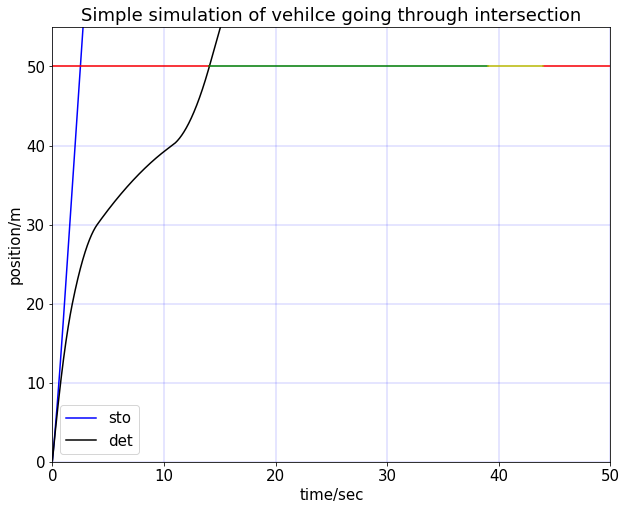

In [45]:
from util import opt_vehicle, traffic_light, vertex
from optimizer import dfs_optimizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import time

def newline(p1, p2, color):
    # draw a line from p1=[x,y] to p2
    ax = plt.gca()
    ymin, ymax = p1[1], p2[1]
    xmin, xmax = p1[0], p2[0]

    l = mlines.Line2D([xmin, xmax], [ymin, ymax], color=color)
    ax.add_line(l)
    return l


start_point = time.time()
################################################
# input part:
timeset = [20, 5, 25]                       # red, yellow, green
t0 = 36                                    # initial clock
light_location = 50

###############################################
# other parameters
delta_x = 10
epslon = 10 ** -6
v_max = 22
delta_t_min = delta_x / v_max
a_min, a_max = -5, 8
w1, w2 = 1/8, 1/8
m = 5
n = 23

light = traffic_light(t0, timeset, light_location)
init_light = light.give_clock(0)
init_state = {
    "x": 0,
    "v": 15,
    "init_light": init_light,
    "t": 0,
    "must_happen": -1,
    "out_edge": [],
    "h": 99999}


x0 = [0, 15, light.give_clock(0), light.give_clock(0)]
car = opt_vehicle(delta_x, v_max, a_max, a_min, light, x0)

#####################################################################
# generate solutions

optimizer = dfs_optimizer(light, car)
U, cost, vel = optimizer.solver(init_state["x"], init_state["v"], 1)

sto_opt = stochastic_light(light, init_state, m, n, v_max, car)

sto_opt.load_prior()

######################################################################
# let's run the result of the mdp
# plot the result trajectory
dt = 0.01
time_real = np.linspace(dt, light.T, 100*light.T)

final_time = light.T
# create the trajcetory
traj_sto = []
vel_sto = []
x_sto = x0
traj_det = []
vel_det = []
x_det = x0
action_mdp = [sto_opt.mdp[sto_opt.mdp["x"] == x0[0]][sto_opt.mdp["v"] == x0[1]]["best_action"].values[0]]

for t in time_real:
    #   stochastic part
    if x_sto[0] // sto_opt.dx + 1 > len(action_mdp):
        if x_sto[0] < sto_opt.light.location + sto_opt.dx:
            print(x_sto, t)
            dt = 1000
            index = -1
            # print(t, x[0], x[1], sto_opt.mdp[sto_opt.mdp["x"] == x[0]][sto_opt.mdp["v"] == x[1]]["t"].values)
            for i in range(len(sto_opt.mdp[sto_opt.mdp["x"] == round(x_sto[0])][sto_opt.mdp["v"] == round(x_sto[1])]["t"].values)):
                t_ = sto_opt.mdp[sto_opt.mdp["x"] == round(x_sto[0])][sto_opt.mdp["v"] == round(x_sto[1])]["t"].values[i]
                if abs(t - t_) < dt:
                    dt = abs(t - t_)
                    index = i
                    new_act = sto_opt.mdp[sto_opt.mdp["x"] == round(x_sto[0])][sto_opt.mdp["v"] == round(x_sto[1])]["best_action"].values[index]
            action_mdp.append(new_act)
        else:
            new_act = 'stop'
    
    u = action_mdp[-1]
    
    x_sto = sto_opt.dynamics(x_sto, u)
    
    x_sto[2] = light.give_clock(t)
    traj_sto.append(x_sto[0])
    vel_sto.append(x_sto[1])
    ##############################
    #    fixed part
    u = optimizer.controller(x_det)
    x_det = optimizer.dynamics(x_det, u)
    x_det[2] = light.give_clock(t)
    traj_det.append(x_det[0])
    vel_det.append(x_det[1])

plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10, 8))
# plot the trajectory
# plt.plot(time_real, S[:, 0])
plt.plot(time_real, traj_sto, 'b')
plt.plot(time_real, traj_det, 'k')
plt.legend(['sto', 'det'])
# plt.plot(time_real, vel, 'b')  

red, green, yellow = light.trafficline(final_time)
red_num, green_num, yel_num = len(red), len(green), len(yellow)
for j in range(int(red_num/2)):
    newline(red[2*j], red[2*j + 1], 'r')
for j in range(int(green_num/2)):
    newline(green[2*j], green[2*j + 1], 'g')
for j in range(int(yel_num/2)):
    newline(yellow[2*j], yellow[2*j + 1], 'y')

plt.xlabel('time/sec')
plt.ylabel('position/m')
plt.xlim([0, light.T])
plt.ylim([0, light_location * 1.1])
#plt.legend(['optimal trajectory', 'red', 'green', 'yellow'])

plt.title('Simple simulation of vehilce going through intersection')
plt.grid(color='b', linestyle='-', linewidth=.2)
# plt.savefig('through_intersec.png')
plt.show()

In [1]:
from util import opt_vehicle, traffic_light, vertex
from optimizer import dfs_optimizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import time
import copy

class stochastic_light:
    # this 'stochastic' here means the vehicle knows the light pattern (green, yellow, red)
    # duration of the signal, but the clock of the light is unkown
    def __init__(self, light, init_state, m, n, v_max, car):
        self.light = light
        self.init_state = init_state
        self.init_light = light.give_clock(0)
        self.light_generate = self.init_light
        self.next_light = self.init_light%3 + 1
        self.car = car
        if self.init_light == 1:
            self.cur_period = self.light.gre_dur
        elif self.init_light == 2:
            self.cur_period = self.light.yel_dur
        else:
            self.cur_period = self.light.red_dur
        self.m = m
        self.n = n
        self.dx = (light.location - init_state["x"]) / m
        self.dv = v_max / (n - 1)
        self.loc_grid = np.linspace(self.dx + init_state["x"], light.location + self.dx, m + 1)
        self.vel_grid = np.linspace(0, v_max, n)
        self.nodes = [] # stores all nodes when generating mdp, in self.expand()
#         filename = str(self.light.red_dur)+'-'+str(self.light.yel_dur)+'-'+str(self.light.gre_dur)+'.csv'

        filename = str(self.init_state["x"]) + '-' + str(self.init_state["v"]) + '-' + str(self.light.red_dur)+'-'+str(self.light.yel_dur)+'-'+str(self.light.gre_dur)+'.csv'
        try:
            self.fixed_result = pd.read_csv(filename, sep='\t')
            print("deterministic file found!")
        except OSError as e:
            print("deterministic file not found!")
            self.generate_deter(filename)
            print("deterministic file generated!")
        self.car = car
        
    def get_cur_period(self):
        if self.light_generate == 1:
            self.cur_period = self.light.gre_dur
        elif self.light_generate == 2:
            self.cur_period = self.light.yel_dur
        else:
            self.cur_period = self.light.red_dur
    
    def unchange_prob_uni(self, state, delta_t):
        # uniform distribution
        return 1 - self.change_prob(state, delta_t)
    
    def change_prob_uni(self, ver, delta_t):
        # uniform distribution
        prob = delta_t/(self.cur_period - ver["t"])
        if prob < 0 :
            prob = 1
        return min(prob, 1)
    
    def change_prob_uni_df(self, index, delta_t):
        prob = delta_t/(self.cur_period - self.node_frame["t"][index])
        if prob < 0:
            prob = 1
        return prob
    
    def unchange_prob_uni_df(self, index, delta_t):
        # uniform distribution
        return 1 - self.change_prob_df(index, delta_t)
    
    def create_descendent(self, ver, x, v):
        
        delta_v = v - ver["v"]
        delta_t = 2 * self.dx/(v + ver["v"])
    
    
        a = delta_v / delta_t
        if a <= a_max and a >= a_min:
            # dynamic check
            j = delta_t * w1 / delta_t_min + abs(a/a_max) * w2
            
            prob = self.change_prob_uni(ver, delta_t)
            if np.isclose(prob, 1):
                new_ver = {
                    "x": x,
                    "v": v,
                    "init_light": self.light_generate,
                    "t": ver["t"] + delta_t,
                    "out_edge": [],
                    "h": 99999,
                    "must_happen": 1}
            else:
                new_ver = {
                    "x": x,
                    "v": v,
                    "init_light": self.light_generate,
                    "t": ver["t"] + delta_t,
                    "out_edge": [],
                    "h": 99999,
                    "must_happen": -1}
            
            # new_ver["in_edge"].append([x, v, delta_t, j, a, prob, light])
            ver["out_edge"].append([x, v, delta_t, j, a, prob, self.light_generate])

#             end expand condition:
#                 1. expand till the intersection location
#                 2. prob of change of one next state is 1, this must happen
            if np.isclose(x, self.loc_grid[-2]):
                new_ver["h"] = float(self.fixed_result[self.fixed_result["init_light"] == self.light_generate][self.fixed_result["x"] == x][self.fixed_result["v"] == v]["cost"].values[0])      # reward for passing the intersection, -100
                
                self.nodes.append(new_ver)
                return
            elif new_ver["must_happen"] > 0:
                # it is going to happen, no descendent
                self.nodes.append(new_ver)
                return
            else:
                self.nodes.append(new_ver)
                self.expand(new_ver)
    
    def expand(self, ver):
        # in python, the address is assigned when you assign one variable
        # to another, so when new vertex is created, as long as it is saved
        # in edge, it's fine
        # some logic:
        # a. if the start light is red (3), at intersection, v>0 is not allowed; before and after intersection, v = 0 is not allowed
        # b. if start light is other, v = 0 is not allowed all spaces
        x = ver["x"] + self.dx
        if x > self.loc_grid[-1]:
            return
        
        if self.light_generate == 3:
            # red light, for safety, assume next state you can only stop
            if np.isclose(x, self.light.location):
                self.create_descendent(ver, x, 0)
            else:
                for v in self.vel_grid[1:]:
                    # no v = 0
                    self.create_descendent(ver, x, v)
        else:
            # other light, need to consider the case that light will change within the travel of last dx to intersection
            if np.isclose(x, self.light.location):
                for v in self.vel_grid:
                    # need to consider if you need to stop at red light
                    self.create_descendent(ver, x, v)
            else:
                for v in self.vel_grid[1:]:
                    # do not need to consider if you need to stop
                    self.create_descendent(ver, x, v)
    
    def backtrack(self):
        # generate the MDP model, which comes from the last column till the first based on Bellman equation
        
        mdp = []
        # 1. first, transfer list to a dataframe
        self.node_frame = pd.DataFrame(self.nodes)
        print('intotal ', len(self.nodes), ' nodes for MDP!')
        
        # 2. second, from the second last column till the first, generate the utility func for each node by Bellman's equation
        # h_1(s) = min_a {p(light change, s1| a, s)*h_2(s1) + p(light not change, s2| a, s)*h_2(s2)
        for i in range(self.m ):
            
            
            x = self.loc_grid[self.m - i - 1] - 10
            print('back track x = ',x)
            for j in self.node_frame[self.node_frame["x"] == x].index:
               
                best_index = 0
                edges = self.node_frame["out_edge"][j]
                if len(edges) > 0:
    #                 edge: [x, v, delta_t, j, a, change_prob, light]
                    # print(self.node_frame[self.node_frame["init_light"] == self.init_light][self.node_frame["x"] == edges[0][0]]["h"].values)
                    
                    prob_change = edges[0][-2]
                    light = edges[0][-1]
                    next_light = light%3 + 1
                    min_h = prob_change * float(self.fixed_result[self.fixed_result["init_light"] == next_light][self.fixed_result["x"] == edges[0][0]][self.fixed_result["v"] == edges[0][1]]["cost"].values[0]) + \
                            (1 - prob_change) * self.node_frame[self.node_frame["x"] == edges[0][0]][self.node_frame["v"] == edges[0][1]][self.node_frame["init_light"] == light]["h"].values[0] + \
                            edges[0][3]
                    
                    
                    if len(edges) > 1:

                        for k in range(1, len(edges)):
                            
                            prob_change = edges[k][-2]
                            h = prob_change * float(self.fixed_result[self.fixed_result["init_light"] == next_light][self.fixed_result["x"] == edges[k][0]][self.fixed_result["v"] == edges[k][1]]["cost"].values[0]) + \
                                (1 - prob_change) * self.node_frame[self.node_frame["x"] == edges[k][0]][self.node_frame["v"] == edges[k][1]][self.node_frame["init_light"] == light]["h"].values[0] + \
                                edges[k][3]
                            if h < min_h:
                                best_index = k
                                min_h = h
                    
                    self.node_frame["h"][j] = min_h
                    # save the result
                    state = {
                        "x" : x,
                        "v" : self.node_frame["v"][j],
                        "t" : self.node_frame["t"][j],
                        "best_action" : edges[best_index][-3],
                        "h" : min_h,
                        "prob_change": edges[best_index][-2],
                        "init_light": light
                    }
                    mdp.append(state)
        
        # then we save the result
        self.mdp_result = pd.DataFrame(mdp)
        filename = str(self.init_state["x"]) + '-' + str(self.init_state["v"]) + '-' + str(self.light.red_dur)+'-'+str(self.light.yel_dur)+'-'+str(self.light.gre_dur)+'_sto.csv'
        self.mdp_result.to_csv(filename, sep='\t')
#         for i in self.node_frame[self.node_frame["x"] == self.dx].index:
#             delta_v = self.node_frame["v"][i] - self.init_state["v"]
#             delta_t = 2 * self.dx / (self.node_frame["v"][i] + self.init_state["v"])
#             a = delta_v / delta_t
#             if a <= self.car.a_max and a >= self.car.a_min:
#                 j = delta_t * self.car.w1 / self.car.delta_t_min + abs(a/self.car.a_max) * self.car.w2
    def load_prior(self):
        filename = str(self.init_state["x"]) + '-' + str(self.init_state["v"]) + '-' + str(self.light.red_dur)+'-'+str(self.light.yel_dur)+'-'+str(self.light.gre_dur)+'_sto.csv'
        print("file to be opened "+ filename)
        
        try:
            self.mdp = pd.read_csv(filename, sep = '\t')
            print("file opened!")
        except OSError as e:
            print(filename + " doesn't exists in the local path!")
#             calculate the time for generating
            a = time.time()
            three_init_time = [a]
            
            for init_light in [1,2,3]:
                print("generate light for light = ", init_light)
                state = copy.deepcopy(self.init_state)
                state["init_light"] = init_light
                self.nodes.append(state)
#                 self.nodes[-1]["init_light"] = init_light
                
                self.light_generate = init_light
                self.get_cur_period()
                self.expand(state)
                b = time.time()
                three_init_time.append(b)
                print('time spent for light ', init_light, ' , is ', three_init_time[init_light] - three_init_time[init_light-1])
            self.backtrack()
            c = time.time()
            print('time spend for MDP generating is ', c - three_init_time[-1])
            print(filename + " exists now!")
            self.mdp = self.mdp_result

    
    def controller(self, x):
        pass
#         if self.go_after_redlight:
#             if x[0] < self.light.location + self.car.delta_x:
#                 return self.optimal_control[-1]
#         if x[0] < self.light.location:
#             if x[2] != 3:
#                 # if x[3] == 3 and self.light.location - x[0] < 0.5 and x[1] == 0:
#                 if x[3] == 3 and self.stop_at_redlight:
#                     self.go_after_redlight = True
#                     return self.optimal_control[-1]
#                 index = math.floor((x[0] - self.car.x0[0])/self.car.delta_x)
#                 # print(x[0], self.car.x0[0], self.car.delta_x, index)
#                 return self.optimal_control[index] + self.feedback_controller(x, index)
#             elif x[3] == 3 and self.light.location - x[0] < 0.5 and abs(x[1]) < 0.5:
#                 self.stop_at_redlight = True
#                 return 'stop'
#             else:
#                 index = math.floor((x[0] - self.car.x0[0])/self.car.delta_x)
#                 # print(x[0], self.car.x0[0], self.car.delta_x, index)
#                 return self.optimal_control[index] + self.feedback_controller(x, index)

#         else:
#             return 0
    
    def dynamics(self, s, u):
        #     state of the system
        #     s_k = (y, v, l, l_p)
        #     s_{k+1} = f(s_k, u_k)

        if u == 'stop':
            vel = 0
            location = s[0]
        else:

            location = s[0] + u * self.car.delta_t ** 2 / 2 + s[1] * self.car.delta_t
            vel = s[1] + u * self.car.delta_t
        lp = s[2]
        l = lp ### l will be updated by external light class
        return [location, vel, l, lp]
    
    def generate_deter(self, filename):
        timeset = [self.light.red_dur, self.light.yel_dur, self.light.gre_dur]
#         loc_grid = np.linspace(dx, light_location + dx, m + 1)
#         vel_grid = np.linspace(0, v_max, n)
        fix_sols = []
        for init_light in [1, 2, 3]:

            opt_light = traffic_light(this_clock(init_light), timeset, self.light.location)
            

            for v in self.vel_grid:
                for x in self.loc_grid[:-1]:
                    
                    x0_ = [x, v, opt_light.give_clock(0)]
                    car = opt_vehicle(self.dx, self.car.v_max, self.car.a_max, self.car.a_min, opt_light, x0_)

                    optimizer = dfs_optimizer(opt_light, car)
                    plan, cost, vel = optimizer.solver(x, v, self.dv)
                    item = {"x": x, 
                           "v": v,
                           "cost": cost,
                           "plan": plan,
                           "vel": vel,
                           "init_light": init_light}
                    fix_sols.append(item)



        self.fixed_result = pd.DataFrame(fix_sols)

        # save the file for future use
        
        self.fixed_result.to_csv(filename, sep='\t')

def next_clock(init_light):
    # try to generate on state's optimal solution
    if init_light == 1:
        # green light, next light is yellow
        t0_opt = light.gre_dur
    elif init_light == 2:
        # yellow light, next light is red
        t0_opt = light.T - light.red_dur
    else:
        # red light, next light is green
        t0_opt = 0
    return t0_opt

def this_clock(init_light):
    # try to generate on state's optimal solution
    if init_light == 1:
        # green light
        t0_opt = 0
    elif init_light == 2:
        # yellow light, next light is red
        t0_opt = light.gre_dur
    else:
        # red light, next light is green
        t0_opt = light.T - light.red_dur
    return t0_opt

In [2]:
from util import opt_vehicle, traffic_light, vertex
from optimizer import dfs_optimizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import time

##############################################
# input here:

# this is for mdp test
# x_init = 20
# v_init = 1
# m = 3
# n = 3

# this is for real test
x_init = 0
v_init = 15
m = 5  # m = light.loc - x_init / dx
n = 23 # n = v_max - 1


t0 = 0                                     # initial clock, irrelavent to mdp generation
light_location = 50
timeset = [26, 5, 25]                      # red, yellow, green

dv = 1
##############################################



v_max = (n-1)*dv
start_point = time.time()
                     # red, yellow, green

delta_x = (light_location - x_init) / m
epslon = 10 ** -6

delta_t_min = delta_x / v_max
a_min, a_max = -5, 8
w1, w2 = 1/8, 1/8


light = traffic_light(t0, timeset, light_location)
init_light = light.give_clock(0)
init_state = {
    "x": x_init,
    "v": v_init,
    "init_light": init_light,
    "t": 0,
    "must_happen": -1,
    "out_edge": [],
    "h": 99999}


x0 = [0, 15, light.give_clock(0), light.give_clock(0)]
car = opt_vehicle(delta_x, v_max, a_max, a_min, light, x0)
light = traffic_light(t0, timeset, light_location)
sto_opt = stochastic_light(light, init_state, m, n, v_max, car)

sto_opt.load_prior()

deterministic file found!
file to be opened 0-15-26-5-25_sto.csv
file opened!


In [3]:
sto_opt.mdp

,Unnamed: 0,x,v,t,best_action,h,prob_change,init_light
0,0,40.0,1.0,14.293372,7.15,0.763962,0.143692,1
1,1,40.0,2.0,10.960039,7.00,0.731399,0.101750,1
2,2,40.0,3.0,9.293372,8.00,0.680288,0.079584,1
3,3,40.0,4.0,8.293372,7.65,0.654599,0.070419,1
4,4,40.0,5.0,7.626706,7.20,0.629594,0.063955,1
...,...,...,...,...,...,...,...,...
13965,13965,10.0,18.0,0.606061,-4.95,9147.540206,0.023866,3
13966,13966,10.0,19.0,0.588235,-3.60,9236.469090,0.021862,3
13967,13967,0.0,15.0,0.000000,6.80,0.989509,0.023529,1
13968,13968,0.0,15.0,0.000000,-4.05,14143.611616,0.148148,2


problem: 
    1. need to add init_light in sto csv!!!!!!!!!!!!!!!!! -- corrected in class, need to correct on CONTROL LOOP
    2. at control loop, specify different conditions, and when light change, look up at the determinisitic file for solu
    3. define feedback!

deterministic file found!
file to be opened 0-15-26-5-25_sto.csv
file opened!


/home/tianqi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/tianqi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:154: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/tianqi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/tianqi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0.0 saved!
deterministic file found!
file to be opened 0-15-26-5-25_sto.csv
file opened!
2.0 saved!
deterministic file found!
file to be opened 0-15-26-5-25_sto.csv
file opened!
4.0 saved!
deterministic file found!
file to be opened 0-15-26-5-25_sto.csv
file opened!
6.0 saved!
deterministic file found!
file to be opened 0-15-26-5-25_sto.csv
file opened!
8.0 saved!
deterministic file found!
file to be opened 0-15-26-5-25_sto.csv
file opened!
10.0 saved!
deterministic file found!
file to be opened 0-15-26-5-25_sto.csv
file opened!
12.0 saved!
deterministic file found!
file to be opened 0-15-26-5-25_sto.csv
file opened!
14.0 saved!
deterministic file found!
file to be opened 0-15-26-5-25_sto.csv
file opened!
16.0 saved!
deterministic file found!
file to be opened 0-15-26-5-25_sto.csv
file opened!
18.0 saved!
deterministic file found!
file to be opened 0-15-26-5-25_sto.csv
file opened!
20.0 saved!
deterministic file found!
file to be opened 0-15-26-5-25_sto.csv
file opened!
22.0 saved!
det

/home/tianqi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:203: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


deterministic file found!
file to be opened 0-15-26-5-25_sto.csv
file opened!
[7.199999999999999] 0.5708333333333333 [0.0, 12.0] [50.00975, -0.05, 1, 1]
[60.086390000000094, 12.045999999999959, 1, 1]
0.009999999999999787 saved!
deterministic file found!
file to be opened 0-15-26-5-25_sto.csv
file opened!
[7.199999999999999] 0.5708333333333333 [0.0, 12.0] [50.00975, -0.05, 1, 1]
[60.086390000000094, 12.045999999999959, 1, 1]
0.009999999999999787 saved!
deterministic file found!
file to be opened 0-15-26-5-25_sto.csv
file opened!
[7.199999999999999] 0.5708333333333333 [0.0, 12.0] [50.00975, -0.05, 1, 1]
[60.086390000000094, 12.045999999999959, 1, 1]
0.009999999999999787 saved!
deterministic file found!
file to be opened 0-15-26-5-25_sto.csv
file opened!
[7.199999999999999] 0.5708333333333333 [0.0, 12.0] [50.00975, -0.05, 1, 1]
[60.086390000000094, 12.045999999999959, 1, 1]
0.009999999999999787 saved!
deterministic file found!
file to be opened 0-15-26-5-25_sto.csv
file opened!
[4.8, 0.0]

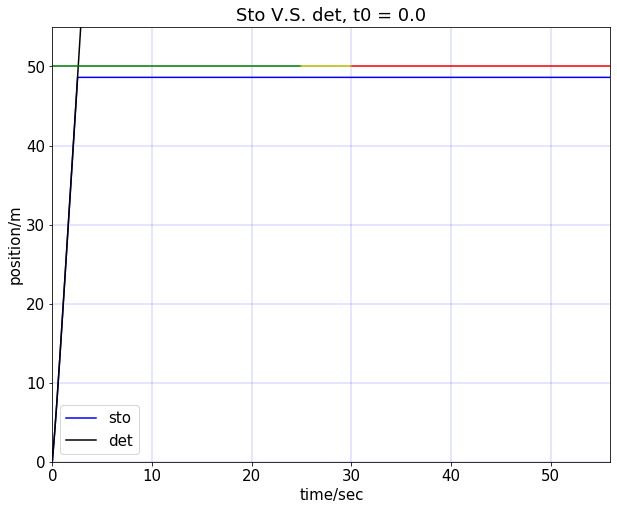

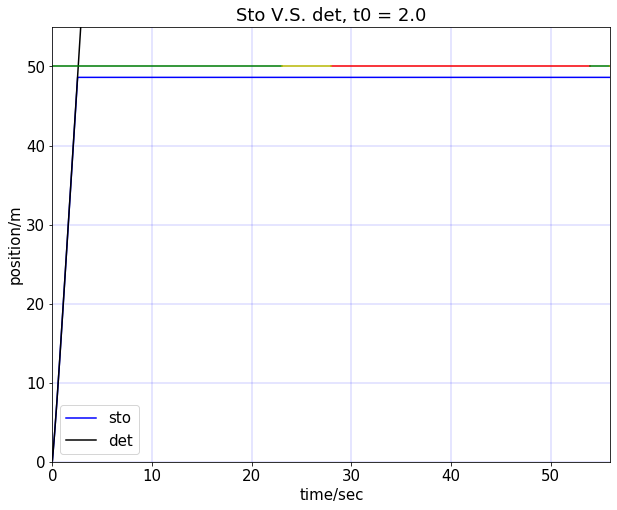

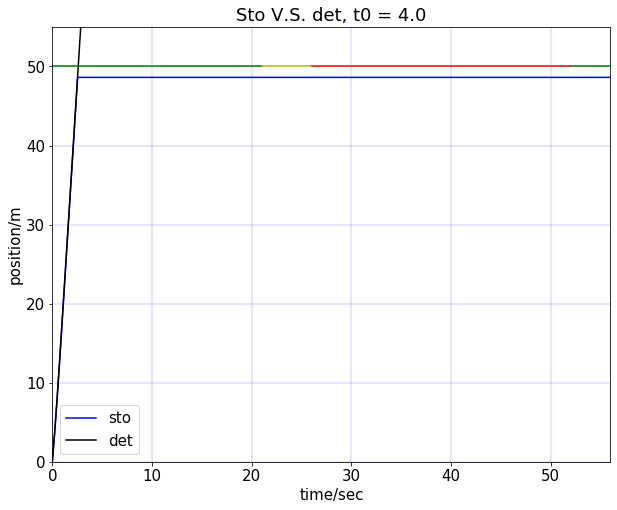

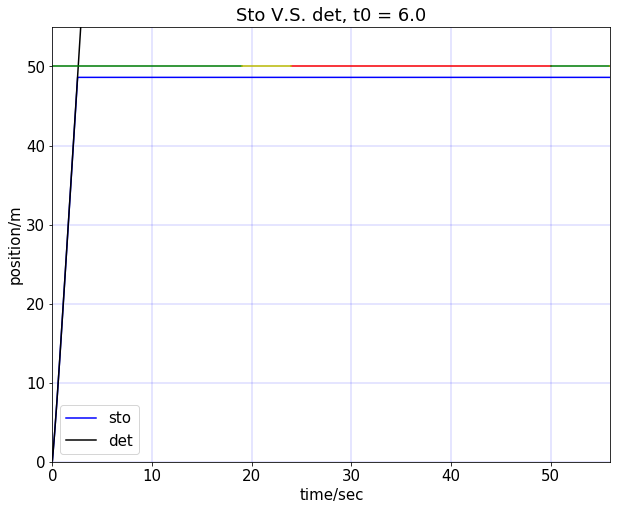

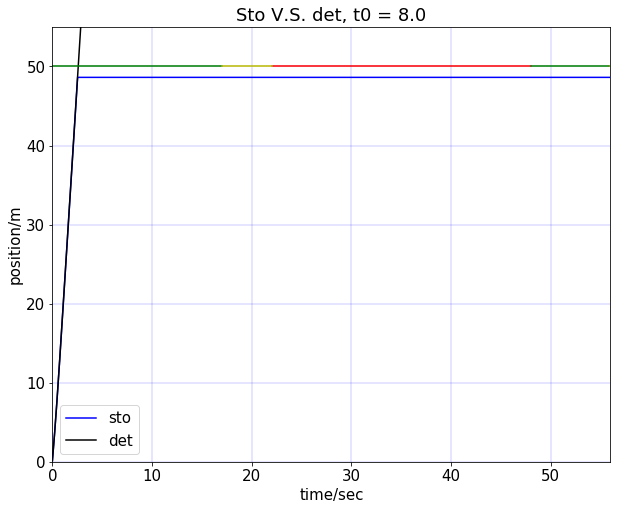

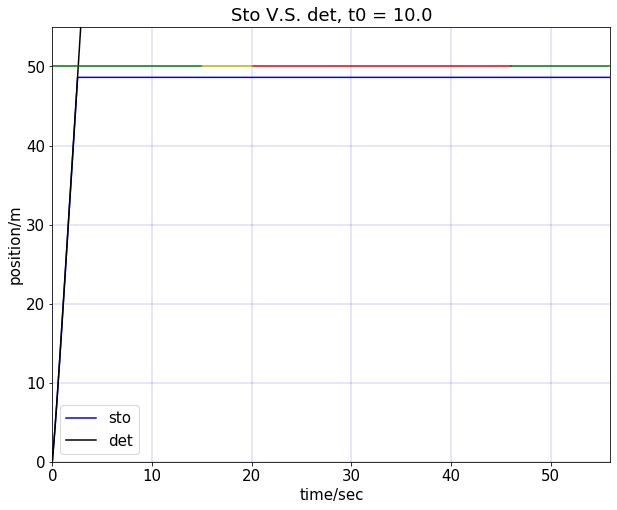

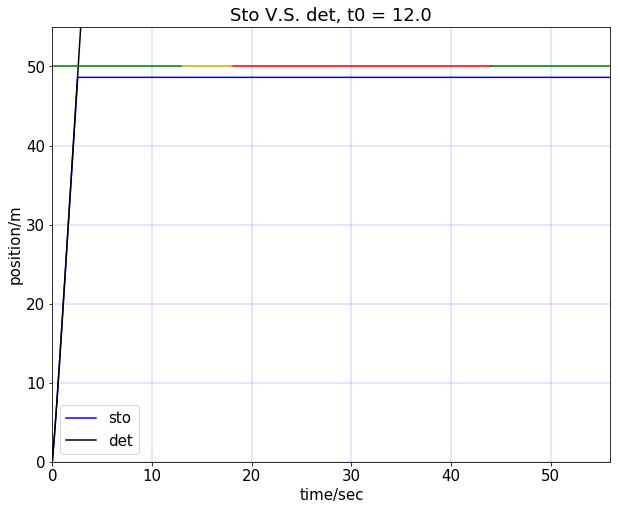

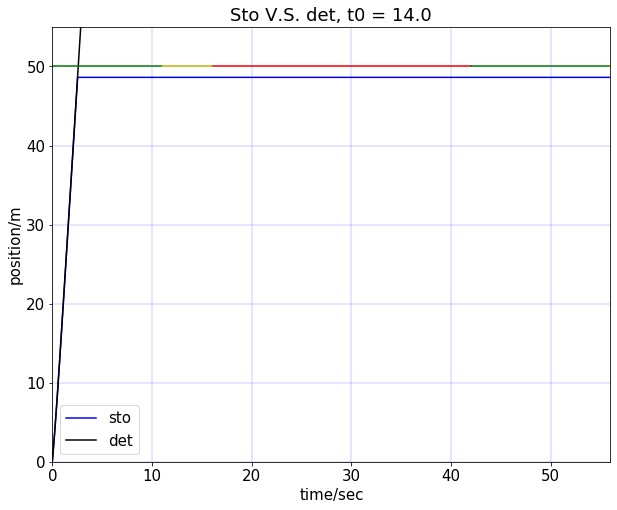

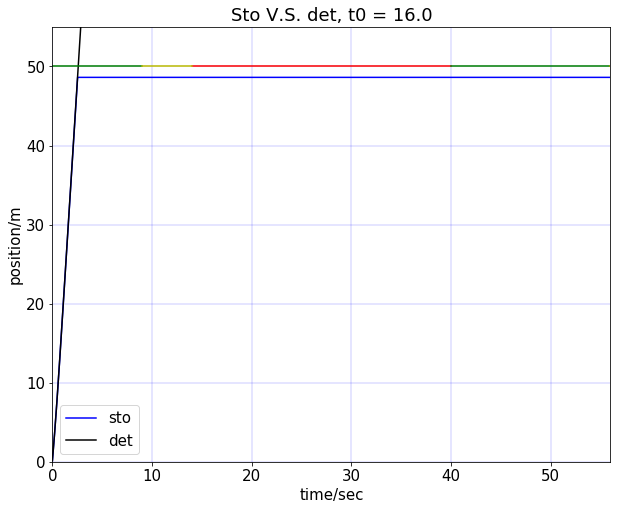

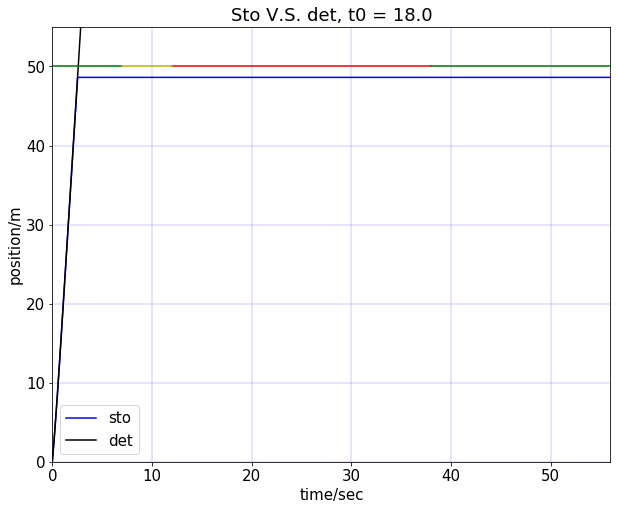

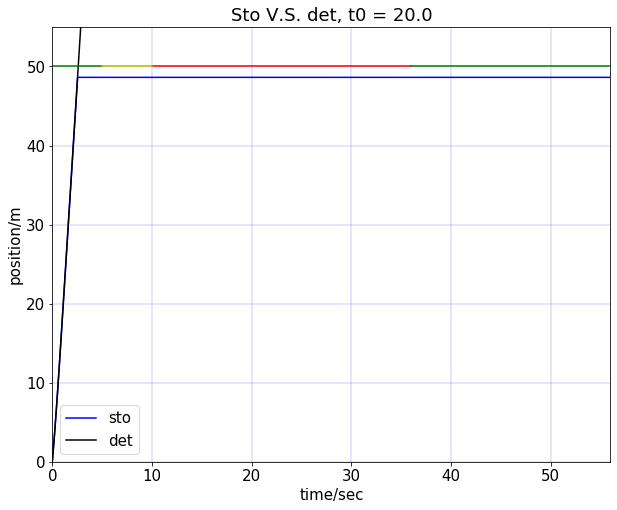

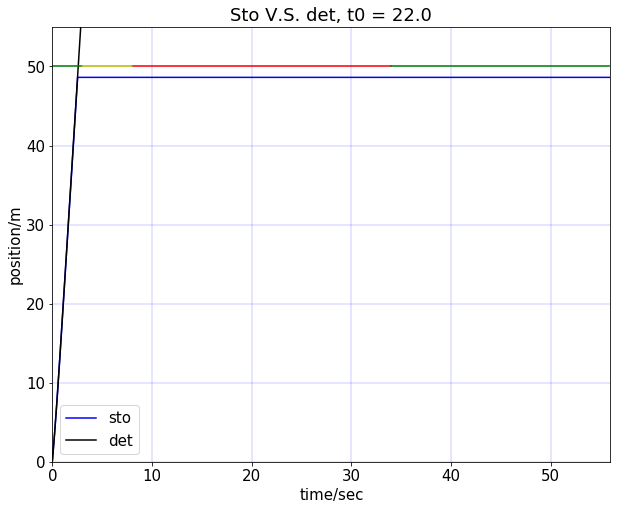

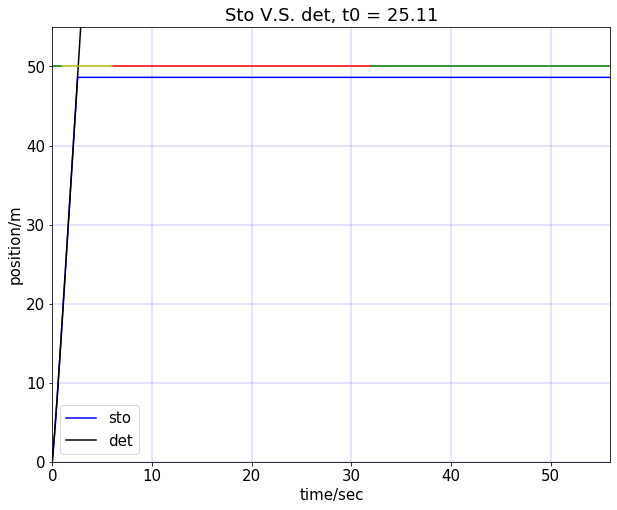

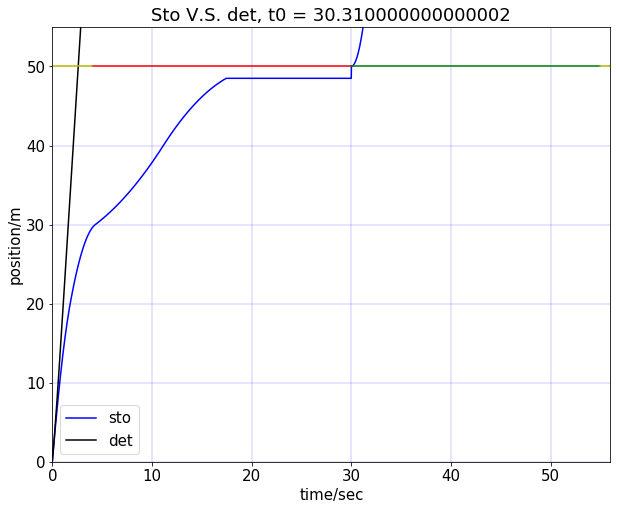

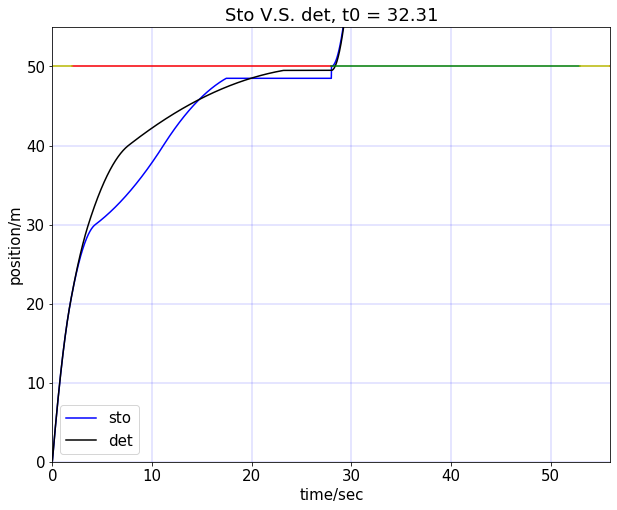

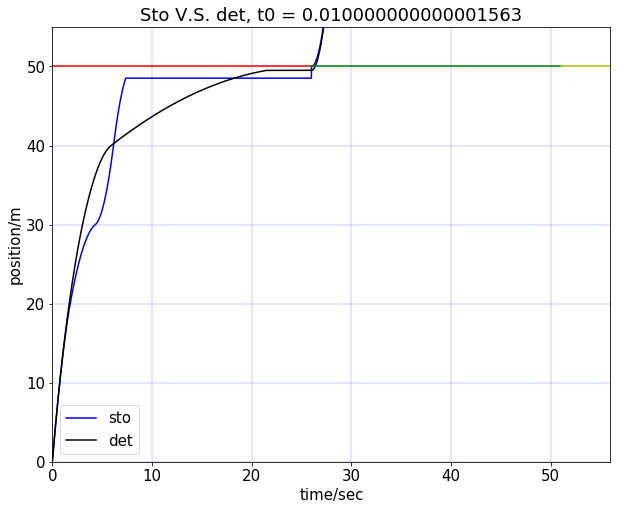

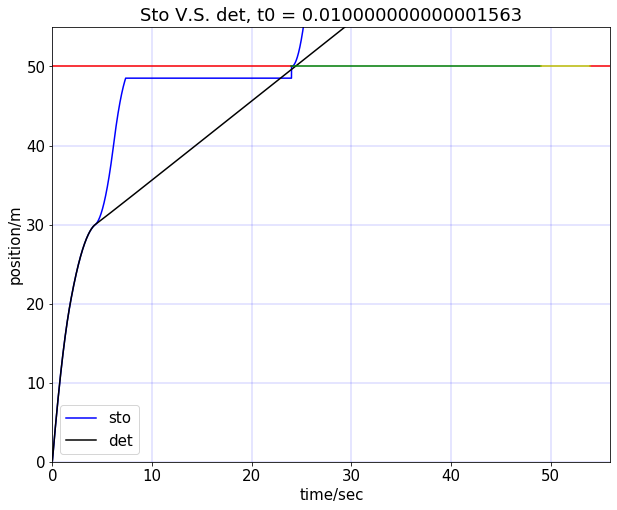

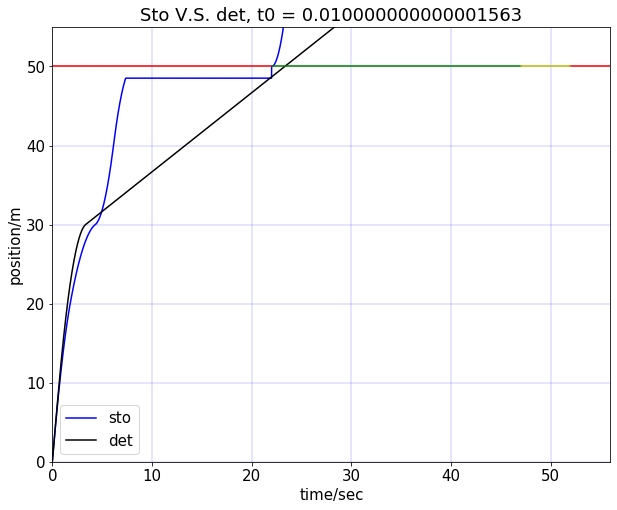

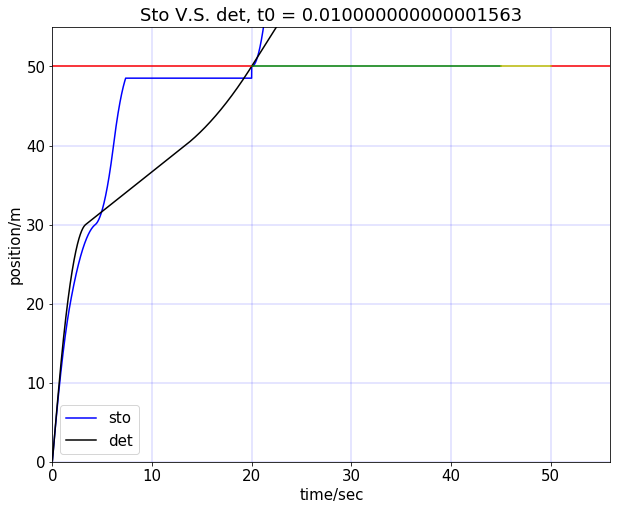

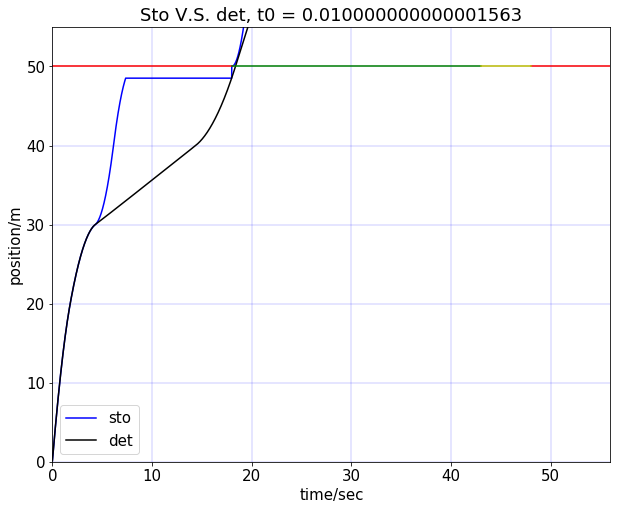

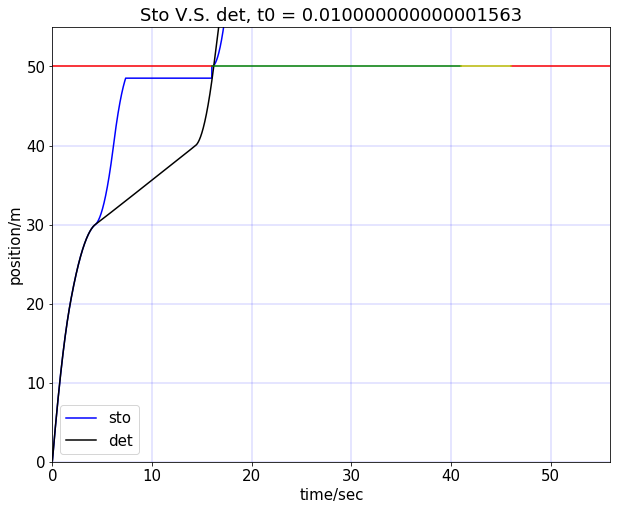

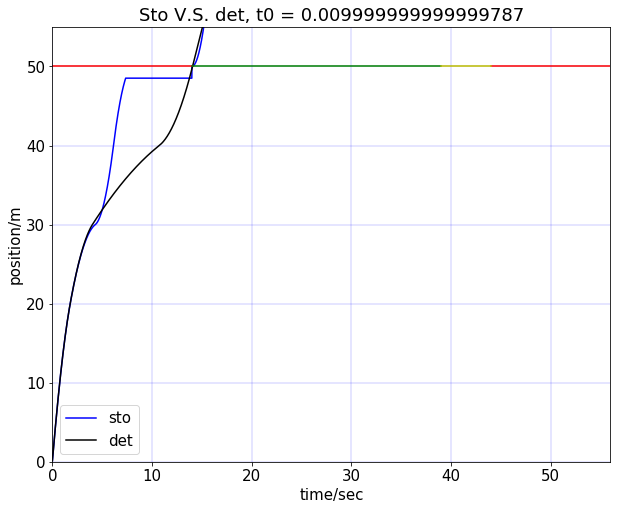

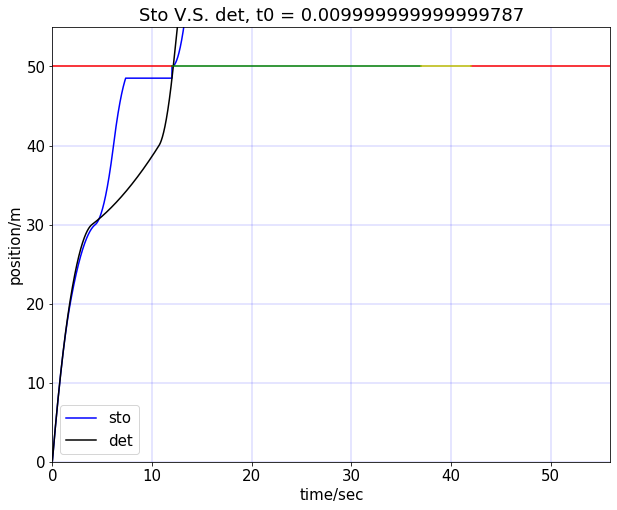

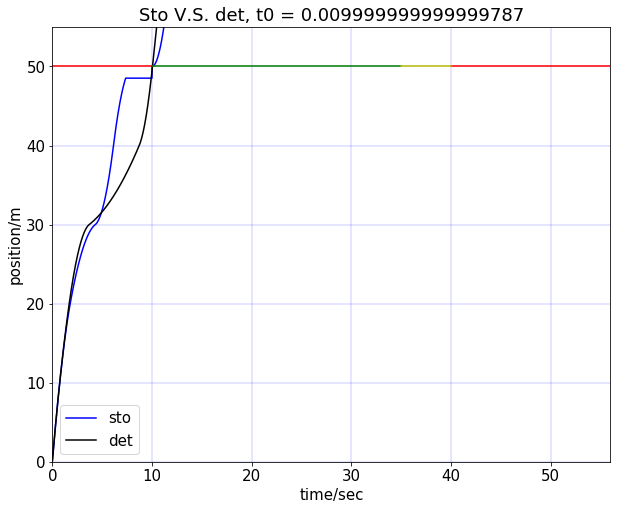

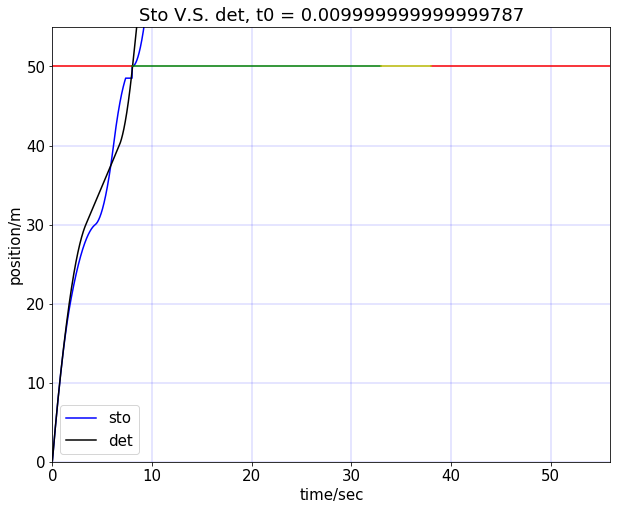

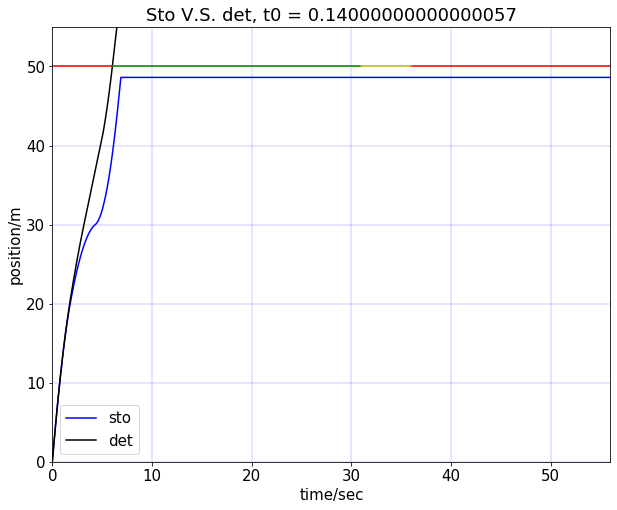

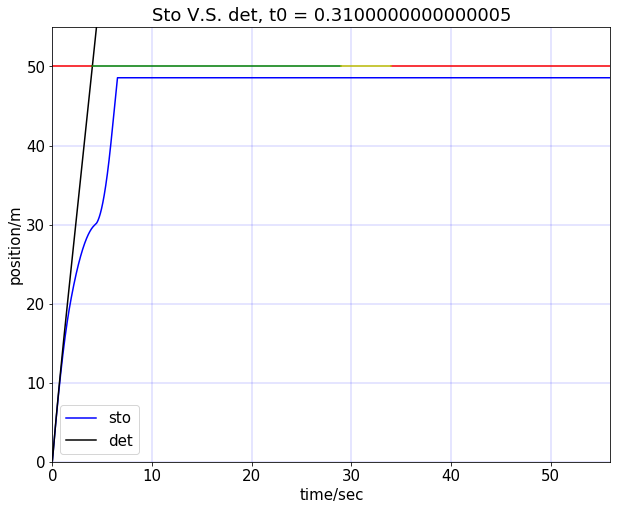

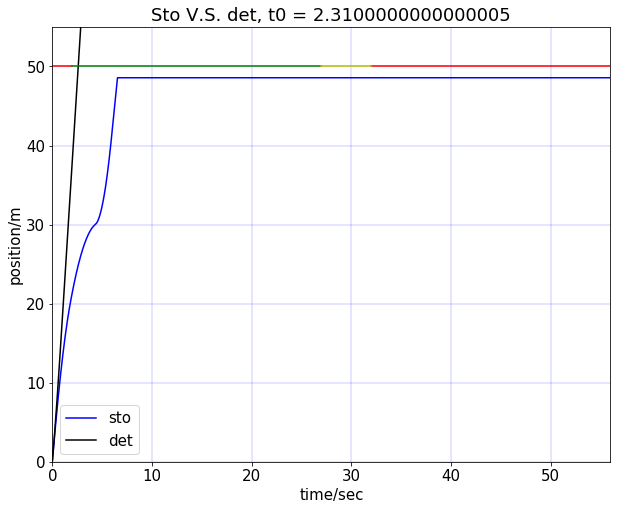

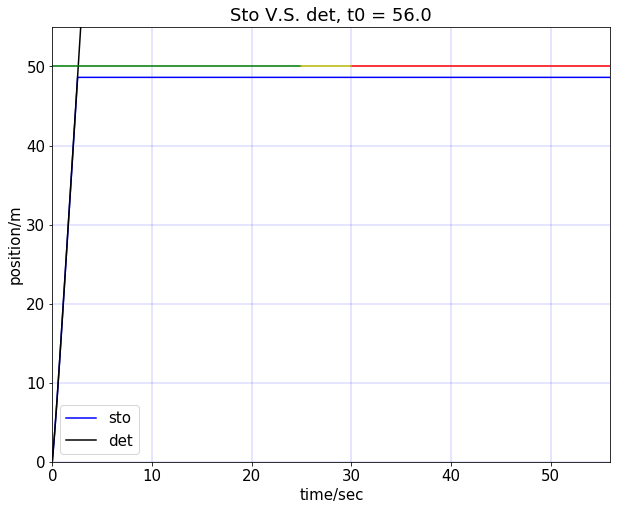

In [8]:
from util import opt_vehicle, traffic_light, vertex
from optimizer import dfs_optimizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import time

def newline(p1, p2, color):
    # draw a line from p1=[x,y] to p2
    ax = plt.gca()
    ymin, ymax = p1[1], p2[1]
    xmin, xmax = p1[0], p2[0]

    l = mlines.Line2D([xmin, xmax], [ymin, ymax], color=color)
    ax.add_line(l)
    return l

def find_nearest(x, n):
#     given x, find nearst integer times of n
    m = x // n

    if x % n > n/2:
        return n*(m + 1)
    else:
        return n*m


start_point = time.time()
x_init = 0
v_init = 15
m = 5  # m = light.loc - x_init / dx
n = 23 # n = v_max - 1


t0 = 36                                    # initial clock, irrelavent to mdp generation
light_location = 50
timeset = [26, 5, 25]                      # red, yellow, green

dv = 1
##############################################



v_max = (n-1)*dv
start_point = time.time()
                     # red, yellow, green

delta_x = (light_location - x_init) / m
epslon = 10 ** -6

delta_t_min = delta_x / v_max
a_min, a_max = -5, 8
w1, w2 = 1/8, 1/8

t0_set = np.linspace(0, sto_opt.light.T, sto_opt.light.T //2 + 1)

for t0 in t0_set:
    t0 = round(t0, 1)

    light = traffic_light(t0, timeset, light_location)
    init_light = light.give_clock(0)
    init_state = {
        "x": x_init,
        "v": v_init,
        "init_light": init_light,
        "t": 0,
        "must_happen": -1,
        "out_edge": [],
        "h": 99999}



    x0 = [0, 15, light.give_clock(0), light.give_clock(0)]
    car = opt_vehicle(delta_x, v_max, a_max, a_min, light, x0)

    #####################################################################
    # generate solutions

    optimizer = dfs_optimizer(light, car)
    U, cost, vel = optimizer.solver(init_state["x"], init_state["v"], 1)

    sto_opt = stochastic_light(light, init_state, m, n, v_max, car)

    sto_opt.load_prior()

    ######################################################################
    # let's run the result of the mdp
    # plot the result trajectory
    dt = 0.01
    time_real = np.linspace(dt, light.T, 100*light.T)

    final_time = light.T
    # create the trajcetory
    traj_sto = []
    vel_sto = []
    x_sto = x0
    traj_det = []
    vel_det = []
    x_det = x0
    action_mdp = [sto_opt.mdp[sto_opt.mdp["x"] == x0[0]][sto_opt.mdp["v"] == x0[1]][sto_opt.mdp["init_light"] == init_light]["best_action"].values[0]]
    light_changed = False
    change_time = 0
    fixed_policy = []
    for t in time_real:
        # x: [x, v, l, lp]
        #   stochastic part
        ##check if the light changed
        if x_sto[-1] != x_sto[-2] and x_sto[0] < sto_opt.light.location:
            #### when light changed, switch to fixed pattern
            light_changed = True
            change_time = t
            # print('light change observed before entering the traffic light location, the position is at x = ', x_sto[0], ', at t = ', t, ', new ligh is ', x_sto[-2])


    #     logic for the following
    #     light_changed: 1. next x after first light change captured -> generate fixed_policy
    #                 2. after this, fixed_policy is not empty, follow the fixed policy
    #     light_changed not: follow mdp for new location gride

        if x_sto[0] // sto_opt.dx + 1 > len(action_mdp):
            # the vehicle goes to a new grid, we should change the policy

            if x_sto[0] < sto_opt.light.location + sto_opt.dx:
                x = find_nearest(x_sto[0], sto_opt.dx)
                v = find_nearest(x_sto[1], sto_opt.dv)

                if light_changed:
                    if len(fixed_policy) == 0:
                        # we should generate the fixed policy!
                        cur_light = x_sto[-2]
                        t0 = this_clock(cur_light) + t - change_time
                        opt_fix_light = traffic_light(t0, timeset, light.location)

                        x0_ = [x, v, opt_fix_light.give_clock(0)]
                        car_fix = opt_vehicle(sto_opt.dx, sto_opt.car.v_max, sto_opt.car.a_max, sto_opt.car.a_min, opt_fix_light, x0_)
                        optimizer_fix = dfs_optimizer(opt_fix_light, car_fix)
                        plan, cost, vel = optimizer_fix.solver(x, v, sto_opt.dv)
                        print(plan, cost, vel, x_sto)
                        plan.reverse()
                        fixed_policy = plan
                        new_act = fixed_policy.pop()
                        action_mdp.append(new_act)
                    else:
    #                     follow the fixed_policy
                        new_act = fixed_policy.pop()
                        action_mdp.append(new_act)
                else:
                    # vehicle does not reach the traffic light yet, and there is not 
    #                 print(x_sto, t)
                    dt = 10000
                    index = -1
                    # print(t, x[0], x[1], sto_opt.mdp[sto_opt.mdp["x"] == x[0]][sto_opt.mdp["v"] == x[1]]["t"].values)
                    for i in range(len(sto_opt.mdp[sto_opt.mdp["x"] == x][sto_opt.mdp["v"] == v][sto_opt.mdp["init_light"] == init_light]["t"].values)):
                        t_ = sto_opt.mdp[sto_opt.mdp["x"] == x][sto_opt.mdp["v"] == v][sto_opt.mdp["init_light"] == init_light]["t"].values[i]
                        if abs(t - t_) < dt:
                            dt = abs(t - t_)
                            index = i
                            new_act = sto_opt.mdp[sto_opt.mdp["x"] == round(x_sto[0])][sto_opt.mdp["v"] == round(x_sto[1])][sto_opt.mdp["init_light"] == init_light]["best_action"].values[index]
                    action_mdp.append(new_act)

            else:
    #             vehicle goes to the end of the road
                print(x_sto)
                new_act = 'stop'
                action_mdp.append(new_act)

        u = action_mdp[-1]

        if  sto_opt.light.location - x_sto[0] < 1.5:
            if x_sto[2] == 3 and x_sto[-1] == 3:
                x_sto[1] = 0
            if x_sto[-1] == 3 and x_sto[-2] == 1:
                x_sto[0] = sto_opt.light.location + 0.01
    #             x_sto = sto_opt.dynamics(x_sto, u)
            if x_sto[0] > sto_opt.light.location:
                x_sto = sto_opt.dynamics(x_sto, u)
        else:

            x_sto = sto_opt.dynamics(x_sto, u)
        # update the light signal



        x_sto[2] = light.give_clock(t)
        traj_sto.append(x_sto[0])
        vel_sto.append(x_sto[1])
        ##############################
        #    fixed part
        u = optimizer.controller(x_det)
        x_det = optimizer.dynamics(x_det, u)

        # update the light signal

        x_det[2] = light.give_clock(t)
        traj_det.append(x_det[0])
        vel_det.append(x_det[1])
        ##############################



    plt.rcParams.update({'font.size': 15})
    plt.figure(figsize=(10, 8))
    # plot the trajectory
    # plt.plot(time_real, S[:, 0])
    plt.plot(time_real, traj_sto, 'b')
    plt.plot(time_real, traj_det, 'k')
    plt.legend(['sto', 'det'])
    # plt.plot(time_real, vel, 'b')  

    red, green, yellow = light.trafficline(final_time)
    red_num, green_num, yel_num = len(red), len(green), len(yellow)
    for j in range(int(red_num/2)):
        newline(red[2*j], red[2*j + 1], 'r')
    for j in range(int(green_num/2)):
        newline(green[2*j], green[2*j + 1], 'g')
    for j in range(int(yel_num/2)):
        newline(yellow[2*j], yellow[2*j + 1], 'y')

    plt.xlabel('time/sec')
    plt.ylabel('position/m')
    plt.xlim([0, light.T])
    plt.ylim([0, light_location * 1.1])
    #plt.legend(['optimal trajectory', 'red', 'green', 'yellow'])

    plt.title('Sto V.S. det, t0 = '+str(t0))
    plt.grid(color='b', linestyle='-', linewidth=.2)
    pic_name = 'pics/t0=' + str(t0) + '.png'
    plt.savefig(pic_name)
    print(t0, 'saved!')
#     plt.show()

In [6]:
t0_set

array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24.,
       26., 28., 30., 32., 34., 36., 38., 40., 42., 44., 46., 48., 50.,
       52., 54., 56.])